<a href="https://colab.research.google.com/github/Barthof/ImageMiningTeamB/blob/main/Citrus_leaves_Resnet50_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

In [ ]:
# Install imbalance learning library
!pip install imblearn

In [ ]:
# Load dataset with info and
# split first 60% of dataset into train_ds and the other two 20% into test_ds and val_ds
(train_ds, test_ds, val_ds), info = tfds.load('citrus_leaves', as_supervised=True, with_info=True, split=["train[:60%]", "train[60%:80%]", "train[80%:]"], shuffle_files=True, batch_size=-1)

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [ ]:
# Split images and labels
image_train, label_train = tfds.as_numpy(train_ds)
image_test, label_test = tfds.as_numpy(test_ds)
image_val, label_val = tfds.as_numpy(val_ds)

In [ ]:
print(image_train.shape)
print(image_test.shape)
print(image_val.shape)
print(label_train.shape) 
print(label_test.shape)
print(label_val.shape)

(356, 256, 256, 3)
(119, 256, 256, 3)
(119, 256, 256, 3)
(356,)
(119,)
(119,)


Shape of image_train: (446, 256, 256, 3)

Shape of label_train: (446,)

Shape of image_test: (148, 256, 256, 3)

Shape of label_test: (148,)

In [ ]:
# Print matrix of image at index 0
print(image_train[0])

[[[217 202 203]
  [218 202 204]
  [220 204 205]
  ...
  [195 186 203]
  [192 186 201]
  [192 185 201]]

 [[218 203 203]
  [219 204 204]
  [220 204 205]
  ...
  [196 187 204]
  [192 185 200]
  [192 185 201]]

 [[218 204 204]
  [219 204 205]
  [220 204 205]
  ...
  [195 185 202]
  [194 186 203]
  [194 187 202]]

 ...

 [[ 76  51  25]
  [ 87  61  32]
  [ 91  62  38]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 62  39  16]
  [ 85  60  34]
  [100  72  45]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 56  35  18]
  [ 68  45  22]
  [102  76  48]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


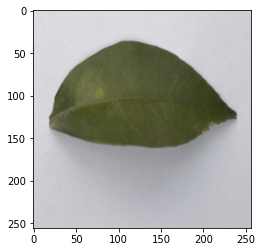

In [ ]:
# Display image
plt.imshow(image_train[1])

In [ ]:
# Extract informative features
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

print("Class names:", class_names)
print("Number of classes:", n_classes)
print("Size of training set:", len(image_train))
print("Unique labels in training set:", np.unique(label_train)) # [0: 'Black spot', 1: 'canker', 2: 'greening', 3: 'healthy']
print("Size of test set:", len(image_test))
print("Unique labels in test set:", np.unique(label_test)) # [0: 'Black spot', 1: 'canker', 2: 'greening', 3: 'healthy']

Class names: ['Black spot', 'canker', 'greening', 'healthy']
Number of classes: 4
Size of training set: 356
Unique labels in training set: [0 1 2 3]
Size of test set: 119
Unique labels in test set: [0 1 2 3]


In [ ]:
# amount per label in training set
# {0: 127, 1: 126, 2: 147, 3: 46}
print("training:", dict(sorted(Counter(label_train).items())))
# amount per label in test set
# {0: 42, 1: 37, 2: 57, 3: 12}
print("test:", dict(sorted(Counter(label_test).items())))

training: {0: 105, 1: 101, 2: 113, 3: 37}
test: {0: 32, 1: 29, 2: 47, 3: 11}


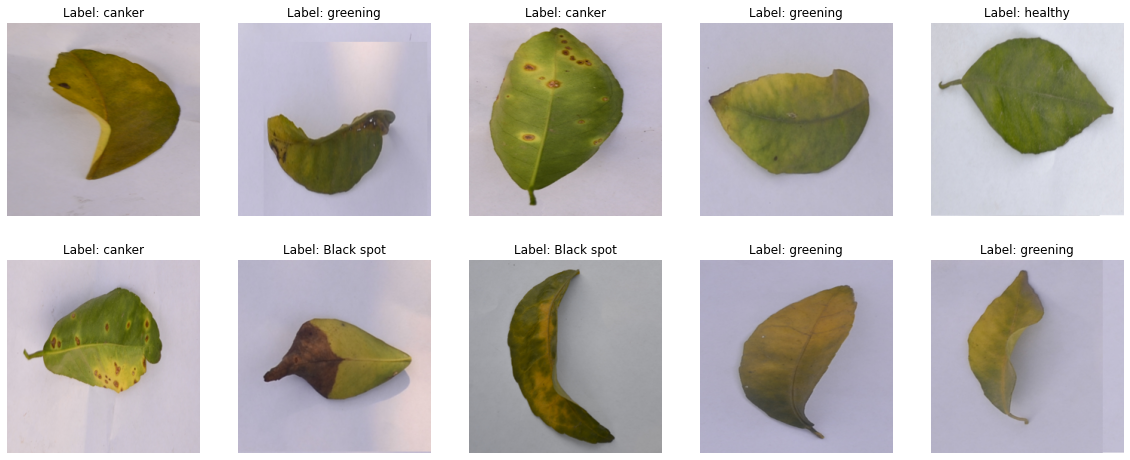

In [ ]:
import matplotlib.pyplot as plt

num_samples = 10

rand_samples = np.random.choice(np.arange(image_train.shape[0]), num_samples)

fig = plt.figure(figsize=(20, 8))
for i in range(num_samples):
    
    im = image_train[rand_samples[i]]
    label = label_train[rand_samples[i]]
    class_label = class_names[label]
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(f"Label: {class_label}")
    ax.axis('off')
    ax.imshow(im)
plt.show()

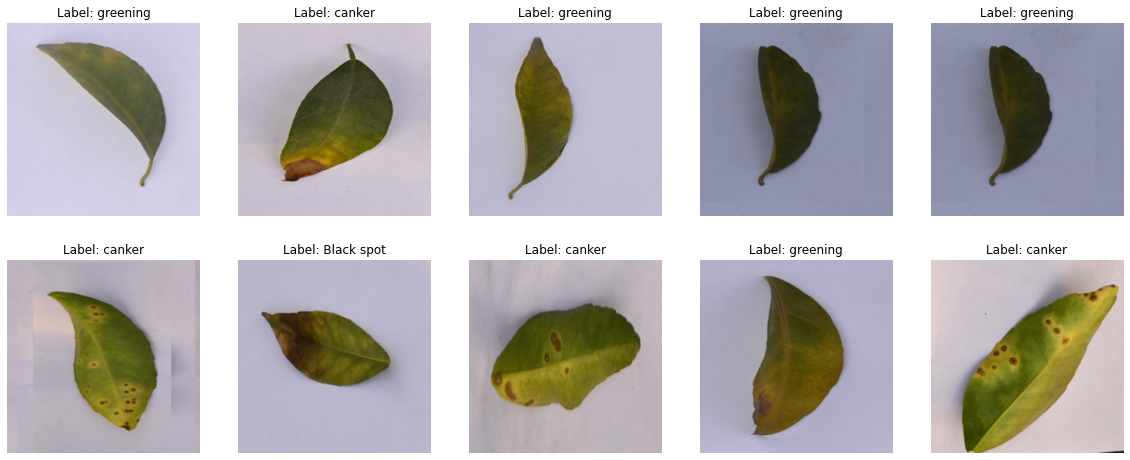

In [ ]:
num_samples = 10

rand_samples = np.random.choice(np.arange(image_test.shape[0]), num_samples)

fig = plt.figure(figsize=(20, 8))
for i in range(num_samples):
    
    im = image_test[rand_samples[i]]
    label = label_test[rand_samples[i]]
    class_label = class_names[label]
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(f"Label: {class_label}")
    ax.axis('off')
    ax.imshow(im)
plt.show()

# Preprocessing

**Data Augmentation**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator as IDG

idg_train = IDG(
    rotation_range=180,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True)

idg_train.fit(image_train)

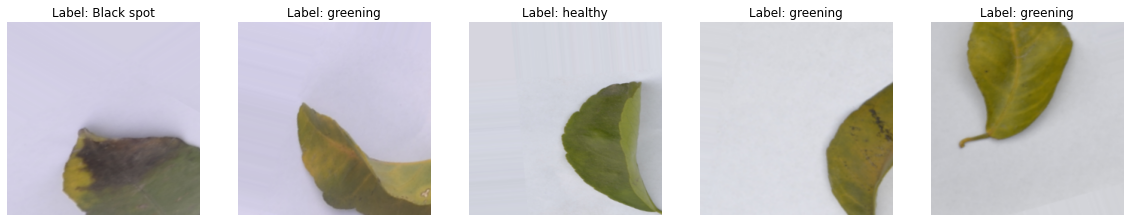

In [ ]:
fig = plt.figure(figsize=(20, 8))
for augmented_train, augmented_label in idg_train.flow(image_train, label_train, batch_size=-1):
    for i in range(0, 5):
        #plt.subplot()
        ax = fig.add_subplot(2, 5, i+1)
        label = augmented_label[i]
        class_label = class_names[label]
        ax.set_title(f"Label: {class_label}")
        ax.axis('off')
        augmented_train = augmented_train.astype('uint8')
        ax.imshow(augmented_train[i].reshape(256, 256, 3))
    break
plt.show()

In [ ]:
print(len(augmented_label))
# amount per label in augmented train set
# {0: 127, 1: 126, 2: 146, 3: 46}
print("augmented:", dict(sorted(Counter(augmented_label).items())))

355
augmented: {0: 104, 1: 101, 2: 113, 3: 37}


In [ ]:
image_train.shape, augmented_train.shape

((356, 256, 256, 3), (355, 256, 256, 3))

In [ ]:
# Append augmented data to original dataset
X_train = np.concatenate((image_train, augmented_train))
y_train = np.concatenate((label_train, augmented_label))

**Oversampling using SMOTE**

In [ ]:
# check version number
import imblearn
print(imblearn.__version__)

# Import SMOTE from imblearn library
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot

0.8.1


Class=0, n=209 (29.395%)
Class=1, n=202 (28.411%)
Class=2, n=226 (31.786%)
Class=3, n=74 (10.408%)


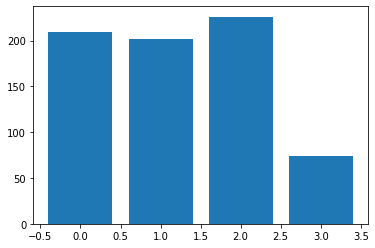

In [ ]:
# summarize distribution
counter = dict(sorted(Counter(y_train).items()))
for k,v in counter.items():
	per = v / len(y_train) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

**Reshape X_train data first**
*   First Flatten the image
*   Apply SMOTE on this flattened image data and its labels
*   Reshape the flattened image to RGB image

In [ ]:
from imblearn.over_sampling import SMOTE
    
sm = SMOTE(random_state=42)
    
train_rows=len(X_train)
X_train = X_train.reshape(train_rows,-1)

X_train, y_train = sm.fit_resample(X_train, y_train)
X_train = X_train.reshape(-1,256,256,3)

In [ ]:
# Print new shapes
print(X_train.shape) # (904, 256, 256, 3)
print(y_train.shape) # (904, 2)

(904, 256, 256, 3)
(904,)


Class=0, n=226 (25.000%)
Class=1, n=226 (25.000%)
Class=2, n=226 (25.000%)
Class=3, n=226 (25.000%)


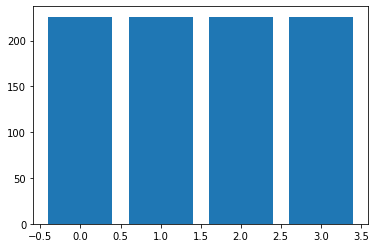

In [ ]:
# Summarize distribution after Smote
counter = dict(sorted(Counter(y_train).items()))
for k,v in counter.items():
	per = v / len(y_train) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

**Fix the name of other val and test data sett**

In [ ]:
# Fix the name and check the shape of validation images
X_val = image_val
print(X_val.shape)
# Fix the name and check the shape of test images
X_test = image_test
print(X_test.shape)

(119, 256, 256, 3)
(119, 256, 256, 3)


**Normalize data**

In [ ]:
X_train=X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

In [ ]:
#print(X_train[0])
print(X_val[0])

[[[0.81568627 0.77647059 0.81176471]
  [0.81960784 0.78039216 0.81568627]
  [0.81176471 0.77254902 0.80784314]
  ...
  [0.79607843 0.75686275 0.78823529]
  [0.78431373 0.75294118 0.78431373]
  [0.78823529 0.75294118 0.78823529]]

 [[0.81176471 0.77254902 0.80784314]
  [0.80784314 0.76862745 0.80392157]
  [0.81568627 0.77647059 0.81176471]
  ...
  [0.78823529 0.75294118 0.79215686]
  [0.78039216 0.74901961 0.79215686]
  [0.78039216 0.74901961 0.79215686]]

 [[0.81568627 0.77647059 0.81176471]
  [0.81176471 0.77254902 0.80784314]
  [0.81176471 0.77254902 0.81176471]
  ...
  [0.78823529 0.74509804 0.78823529]
  [0.78039216 0.74117647 0.78431373]
  [0.78039216 0.74117647 0.78431373]]

 ...

 [[0.75686275 0.7254902  0.78431373]
  [0.75686275 0.7254902  0.78431373]
  [0.75686275 0.7254902  0.78431373]
  ...
  [0.77647059 0.72941176 0.79215686]
  [0.78431373 0.74117647 0.79607843]
  [0.78431373 0.74117647 0.8       ]]

 [[0.76470588 0.7254902  0.78823529]
  [0.75686275 0.7254902  0.78431373]


**One Hot Encoding**

In [ ]:
# One hot encoder labels
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.reshape(-1, 1))

y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_val = enc.transform(label_val.reshape(-1, 1)).toarray()
y_test = enc.transform(label_test.reshape(-1, 1)).toarray()
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(904, 4)
(119, 4)
(119, 4)


# Transfer learning with Resnet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Flatten, Dense 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from tqdm import tqdm
import os
from pickle import dump

One requirement of the neural network model was to define the input shape, hence, all the images needed to in the same shape.

In [ ]:
X_train[0].shape

(256, 256, 3)

In [ ]:
input_shape = X_train[0].shape

In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# make smaller batches to prevent overflowing RAM
ds_train = ds_train.batch(56)
ds_val = ds_val.batch(56)

**Define the model**

In [ ]:
base_model = ResNet50(weights="imagenet",
                      input_shape=input_shape, 
                      include_top=False)

inputs = Input(shape=input_shape)
x = base_model(inputs, training=True)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(n_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1024)              134218752 
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 157,810,564
Trainable params: 157,757,444
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
# we need to recompile our model
model.compile(optimizer=Adam(1e-4),  # 1e-4 learning rate
              loss=CategoricalCrossentropy(),
              metrics=[CategoricalAccuracy()])

In [ ]:
num_epochs = 5

history = model.fit(ds_train, validation_data=ds_val, epochs=num_epochs)

Epoch 1/5
17/17 [==============================] - 62s 3s/step - loss: 8.1668 - categorical_accuracy: 0.4646 - val_loss: 3.5857 - val_categorical_accuracy: 0.4034
Epoch 2/5
17/17 [==============================] - 41s 2s/step - loss: 1.2874 - categorical_accuracy: 0.6659 - val_loss: 0.3250 - val_categorical_accuracy: 0.8487
Epoch 3/5
17/17 [==============================] - 41s 2s/step - loss: 0.4466 - categorical_accuracy: 0.8861 - val_loss: 0.3157 - val_categorical_accuracy: 0.8908
Epoch 4/5
17/17 [==============================] - 41s 2s/step - loss: 0.0912 - categorical_accuracy: 0.9679 - val_loss: 0.2313 - val_categorical_accuracy: 0.9160
Epoch 5/5
17/17 [==============================] - 40s 2s/step - loss: 0.0174 - categorical_accuracy: 0.9956 - val_loss: 0.1644 - val_categorical_accuracy: 0.9244


**Results**

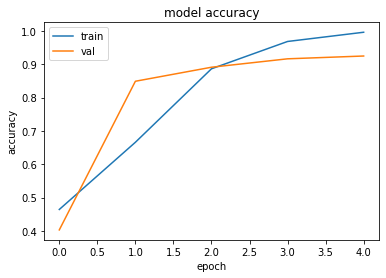

In [ ]:
# Accuracy plot
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

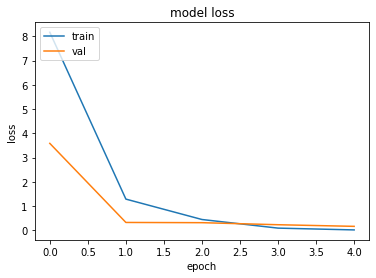

In [ ]:
# Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluate the generated Model (Testing)

In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 359ms/step - loss: 0.2867 - categorical_accuracy: 0.9160


[0.28671616315841675, 0.9159663915634155]

# Prediction for creating a Confusion matrix

In [ ]:
result=model.predict(X_test)

In [ ]:
result

array([[7.12854385e-01, 3.37772217e-05, 2.87090391e-01, 2.14850388e-05],
       [2.18553111e-01, 7.80869246e-01, 5.66249713e-04, 1.14855493e-05],
       [5.10458012e-05, 1.63494357e-11, 9.99948978e-01, 1.36619702e-08],
       [9.99357164e-01, 5.99472072e-09, 6.42780797e-04, 6.54903154e-09],
       [1.40421083e-02, 1.07989200e-08, 9.85957384e-01, 5.23265498e-07],
       [3.99902594e-12, 5.44542987e-11, 4.42867375e-11, 1.00000000e+00],
       [3.29536810e-12, 2.34063788e-12, 3.10342238e-11, 1.00000000e+00],
       [1.24997574e-25, 1.00000000e+00, 1.26752877e-28, 2.62310371e-17],
       [9.98657227e-01, 3.58376225e-13, 1.34270568e-03, 5.64975042e-13],
       [4.28697349e-05, 1.17988371e-11, 9.99957085e-01, 6.33325259e-09],
       [2.62128763e-10, 1.78016255e-10, 3.15635101e-10, 1.00000000e+00],
       [5.32631357e-18, 1.00000000e+00, 4.06609657e-22, 2.91431430e-13],
       [9.99834538e-01, 1.40375811e-09, 1.65383040e-04, 5.34047750e-10],
       [1.89091805e-02, 7.04594299e-07, 9.80897725e

In [ ]:
result[0]

array([7.1285439e-01, 3.3777222e-05, 2.8709039e-01, 2.1485039e-05],
      dtype=float32)

In [ ]:
# Get the index of prediction 

y_true=[]
y_pred=[]
for i in range(len(result)):
    y_true.append(np.argmax(y_test[i]))
    y_pred.append(np.argmax(result[i]))

In [ ]:
print('True label', y_true)
print('Pred label:', y_pred)

True label [2, 1, 2, 0, 2, 3, 3, 1, 0, 2, 3, 1, 0, 2, 1, 0, 3, 1, 1, 2, 1, 0, 2, 2, 2, 0, 1, 2, 1, 2, 2, 0, 1, 0, 1, 3, 2, 2, 2, 3, 3, 1, 0, 1, 0, 2, 2, 2, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 1, 0, 2, 0, 3, 1, 1, 1, 2, 2, 0, 1, 1, 2, 0, 2, 3, 2, 1, 2, 2, 2, 0, 0, 0, 3, 0, 0, 1, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 1, 1, 1, 2, 2, 2, 2, 0, 2, 0, 3, 2]
Pred label: [0, 1, 2, 0, 2, 3, 3, 1, 0, 2, 3, 1, 0, 2, 1, 0, 3, 1, 1, 2, 1, 0, 2, 2, 2, 0, 1, 2, 1, 2, 2, 0, 1, 0, 1, 3, 2, 2, 2, 3, 3, 1, 0, 1, 2, 2, 2, 2, 0, 1, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 1, 0, 1, 2, 2, 0, 2, 1, 1, 0, 2, 2, 3, 1, 2, 1, 2, 2, 0, 1, 1, 2, 0, 2, 3, 2, 1, 2, 2, 2, 0, 0, 0, 3, 2, 0, 1, 2, 2, 2, 2, 3, 0, 2, 0, 2, 2, 1, 1, 1, 2, 2, 2, 2, 0, 2, 0, 3, 2]


In [ ]:
np.unique(y_true),np.unique(y_pred)

(array([0, 1, 2, 3]), array([0, 1, 2, 3]))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Confusion Matrix

In [ ]:
len(y_test)

119

In [ ]:
mat=confusion_matrix(y_true, y_pred)
mat

array([[26,  0,  6,  0],
       [ 1, 27,  1,  0],
       [ 1,  0, 45,  1],
       [ 0,  0,  0, 11]])

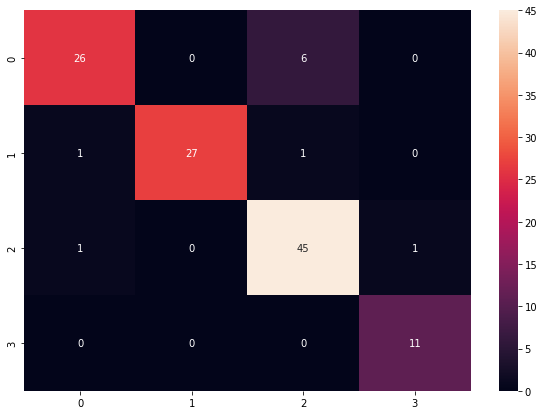

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

classes = ["0","1", "2", "3"]

'''
"0"--> label Black Spot
"1"--> label Canker
"2"--> label Greening
"3"--> label Healthy
'''


df_cfm = pd.DataFrame(mat, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot=True)
#cfm_plot.figure.savefig('/content/gdrive/MyDrive/result_CNN_1_5_REV/confusion_matrix.png')
plt.show()
#true y axis
# pred x axis

# Score of each class

In [ ]:
score_each_class=[]
temp=[]
for i in range(len(mat)):
    temp_sum=sum(mat[i])
    
    for j in range(len(mat[i])):
        temp.append(mat[i][j]/temp_sum)
    score_each_class.append(temp)
    temp=[]
    
score_each_class

[[0.8125, 0.0, 0.1875, 0.0],
 [0.034482758620689655, 0.9310344827586207, 0.034482758620689655, 0.0],
 [0.02127659574468085, 0.0, 0.9574468085106383, 0.02127659574468085],
 [0.0, 0.0, 0.0, 1.0]]

# Recall, precision, F1-score

In [ ]:
from sklearn.metrics import precision_score

precision_score(y_true, y_pred, average='macro')

0.9276556776556776

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_true, y_pred, average='macro')

0.9252453228173148

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro')


0.9241412572934311